In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
benign_data_path = '../../Smart Attack Algorithm/data/Car Hacking Dataset/benign_data.csv'
non_perturbed_data = 'Adversarial_traffic_None.csv'

In [3]:
benign_data = pd.read_csv(benign_data_path)
benign_data.head()

,Timestamp,ID,DLC,Payload,label
0,1.479121e+09,0350,8,052884666d0000a2,0
1,1.479121e+09,02c0,8,1400000000000000,0
2,1.479121e+09,0430,8,0000000000000000,0
3,1.479121e+09,04b1,8,0000000000000000,0
4,1.479121e+09,01f1,8,0000000000000000,0


In [4]:
non_perturbed_data = pd.read_csv(non_perturbed_data)
non_perturbed_data.head()

,TS,ID,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,Label
0,0.000000,000,8,00,00,00,00,00,00,00,00,1
1,0.005460,000,8,00,00,00,00,00,00,00,00,1
2,0.011176,140,8,00,00,00,00,1c,07,26,28,0
3,0.016722,000,8,00,00,00,00,00,00,00,00,1
4,0.016960,316,8,05,21,74,09,21,20,00,6f,0


In [5]:
def construct_payload(row):
    dlc = int(row["DLC"])  # Number of valid data columns
    data_values = [row[f"Data{i}"] for i in range(1, dlc + 1) if f"Data{i}" in row]
    return "".join(map(str, data_values))

non_perturbed_data["Payload"] = non_perturbed_data.apply(construct_payload, axis=1)
# Keep only the required columns
non_perturbed_data = non_perturbed_data[["TS", "ID", "DLC", "Payload", "Label"]]
## Rename the columns to Timestamp, ID, DLC, Data, and Label
non_perturbed_data.columns = ["Timestamp", "ID", "DLC", "Payload", "label"]

non_perturbed_data.head()

,Timestamp,ID,DLC,Payload,label
0,0.000000,000,8,0000000000000000,1
1,0.005460,000,8,0000000000000000,1
2,0.011176,140,8,000000001c072628,0
3,0.016722,000,8,0000000000000000,1
4,0.016960,316,8,052174092120006f,0


In [6]:
hex_to_dec = lambda x: int(str(x), 16)

def transform_data(data):

    data['ID'] = data['ID'].apply(hex_to_dec)
    data['Payload'] = data['Payload'].apply(hex_to_dec)

    return data

benign_data = transform_data(benign_data)
non_perturbed_data = transform_data(non_perturbed_data)

In [7]:
benign_data.head()

,Timestamp,ID,DLC,Payload,label
0,1.479121e+09,848,8,371692544708313250,0
1,1.479121e+09,704,8,1441151880758558720,0
2,1.479121e+09,1072,8,0,0
3,1.479121e+09,1201,8,0,0
4,1.479121e+09,497,8,0,0


In [8]:
def split_into_windows(df, window_size):
    """
    Split dataset into windows of a given size and assign a label to each window.
    
    Args:
        df (pd.DataFrame): Input dataframe.
        window_size (float): Window size in seconds.
        
    Returns:
        list: List of windowed dataframes.
        list: List of labels for each window (1 if any data point in the window is 1, else 0).
        int: Number of windows.
    """
    start_time = df['Timestamp'].min()
    end_time = df['Timestamp'].max()
    
    windows = []
    window_labels = []  # To store the label for each window
    current_time = start_time
    
    while current_time <= end_time:
        # Extract data for the current window
        window = df[(df['Timestamp'] >= current_time) & 
                    (df['Timestamp'] < current_time + window_size)]
        
        if not window.empty:
            windows.append(window)
            
            # Assign window label: 1 if any label is 1 in the window, else 0
            if (window['label'] == 1).any():
                window_labels.append(1)
            else:
                window_labels.append(0)
        
        # Move to next window
        current_time += window_size
    
    return windows, window_labels, len(windows)

def calculate_entropy(windows):
    """
    Calculate entropy for each window.
    
    Args:
        windows (list): List of windowed dataframes.
        
    Returns:
        list: List of entropy values for each window.
    """
    entropies = []
    
    for window in windows:
        # Count unique combinations of Identifier, Data Length Code, and Data
        counts = window.groupby(['ID', 'DLC', 'Payload']).size()
        total = counts.sum()
        
        if total > 0:
            # Compute probability
            probabilities = counts / total
            
            # Calculate entropy using the definition
            entropy = -np.sum(probabilities * np.log2(probabilities))
            entropies.append(entropy)
    
    return entropies



def plot_entropy(entropy_dict, window_labels_dict, show_labels=True):
    """
    Plots entropy across time windows. If show_labels is True, creates separate plots 
    for each window size, distinguishing attack (label=1) and benign (label=0) windows.

    Args:
        entropy_dict (dict): Dictionary mapping window size to entropy values.
        window_labels_dict (dict): Dictionary mapping window size to window labels.
        show_labels (bool): Whether to plot attack and benign windows separately.
    """
    
    if show_labels:
        for window_size, entropies in entropy_dict.items():
            labels = window_labels_dict[window_size]
            x = np.arange(len(entropies))  # X-axis: Window indices
            
            attack_indices = [idx for idx, lbl in enumerate(labels) if lbl == 1]
            benign_indices = [idx for idx, lbl in enumerate(labels) if lbl == 0]

            plt.figure(figsize=(10, 5))
            
            plt.scatter(attack_indices, [entropies[idx] for idx in attack_indices], 
                        color='red', label='Attack', marker='x')

            plt.scatter(benign_indices, [entropies[idx] for idx in benign_indices], 
                        color='blue', label='Benign', marker='o')

            plt.title(f'Entropy Across Time Windows - Window Size {window_size}s')
            plt.xlabel('Window Index')
            plt.ylabel('Entropy')
            plt.legend()
            plt.grid(True)
            plt.show()

    else:
        plt.figure(figsize=(12, 6))
        colors = ['blue', 'green', 'red']  # Colors for each window size
        
        for i, (window_size, entropies) in enumerate(entropy_dict.items()):
            x = np.arange(len(entropies))  # X-axis: Window indices
            plt.plot(x, entropies, label=f'Window size: {window_size}s', 
                     color=colors[i % len(colors)], marker='o', linestyle='-')

        #
        plt.xlabel('Window Index')
        plt.ylabel('Entropy')
        plt.legend()
        plt.grid(True)
        plt.show()


In [9]:
def data_len(df):
    if 'Timestamp' in df.columns:
        # Ensure the Timestamp column is sorted
        df = df.sort_values(by='Timestamp')
        
        # Compute time difference
        time_diff = df['Timestamp'].iloc[-1] - df['Timestamp'].iloc[0]
        
        # Convert to HH:MM:SS:Milliseconds format
        hours, remainder = divmod(time_diff, 3600)
        minutes, remainder = divmod(remainder, 60)
        seconds, milliseconds = divmod(remainder, 1)
        
        time_str = f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}:{int(milliseconds * 1000):03}"
        
        return time_str
    else:
        return "Timestamp column not found in dataframe"

In [10]:
train_data, val_data = train_test_split(benign_data, test_size = 0.5, shuffle = True)

In [11]:
data_len(train_data)

'00:08:26:436'

In [12]:
data_len(val_data)

'00:08:26:436'

In [13]:
## For finding mean and std-dev

print("Train data")

entropy_dict = {}  # Dictionary to store entropy values by window size
window_labels_dict = {}  # Stores window labels by window size

window_sizes = [1, 0.5, 0.1]  # in seconds
for window_size in window_sizes:
    windows, window_labels, num_windows = split_into_windows(train_data, window_size)
    entropies = calculate_entropy(windows)
    
    # Store entropy values in dictionary
    entropy_dict[window_size] = entropies
    window_labels_dict[window_size] = window_labels

    
    print(f"Window size: {window_size} seconds")
    print(f"Number of windows: {num_windows}")
    print(f"Average entropy: {np.mean(entropies):.4f}\n")

print('\n\n\n\n')

print("Validation data")

val_entropy_dict = {}  # Dictionary to store entropy values by window size
val_window_labels_dict = {}  # Stores window labels by window size

window_sizes = [1, 0.5, 0.1]  # in seconds
for window_size in window_sizes:
    val_windows, val_window_labels, val_num_windows = split_into_windows(val_data, window_size)
    val_entropies = calculate_entropy(val_windows)
    
    # Store entropy values in dictionary
    val_entropy_dict[window_size] = val_entropies
    val_window_labels_dict[window_size] = val_window_labels

    
    print(f"Window size: {window_size} seconds")
    print(f"Number of windows: {val_num_windows}")
    print(f"Average entropy: {np.mean(val_entropies):.4f}\n")


Train data
Window size: 1 seconds
Number of windows: 507
Average entropy: 7.8417

Window size: 0.5 seconds
Number of windows: 1013
Average entropy: 7.2560

Window size: 0.1 seconds
Number of windows: 5065
Average entropy: 5.8115






Validation data
Window size: 1 seconds
Number of windows: 507
Average entropy: 7.8438

Window size: 0.5 seconds
Number of windows: 1013
Average entropy: 7.2585

Window size: 0.1 seconds
Number of windows: 5065
Average entropy: 5.8127



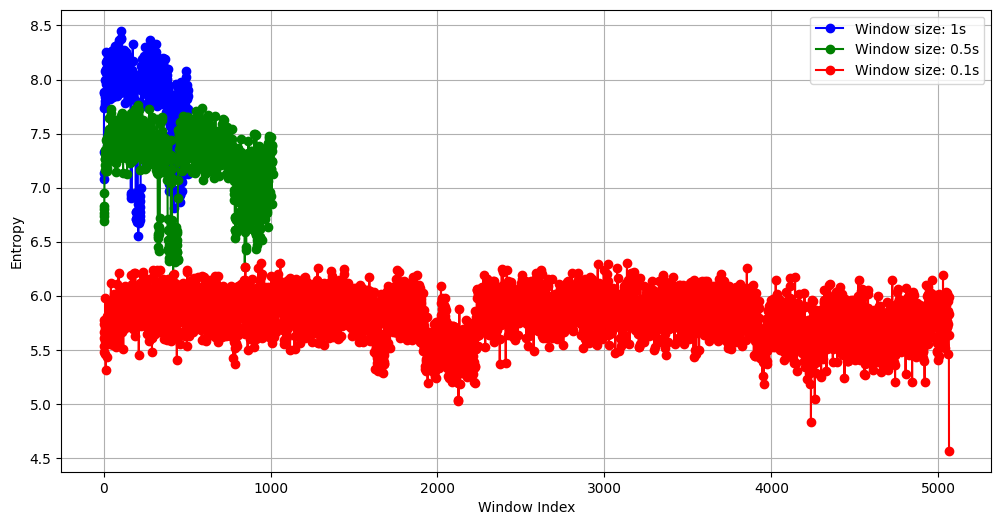

In [14]:
plot_entropy(entropy_dict, window_labels_dict, show_labels=False) 

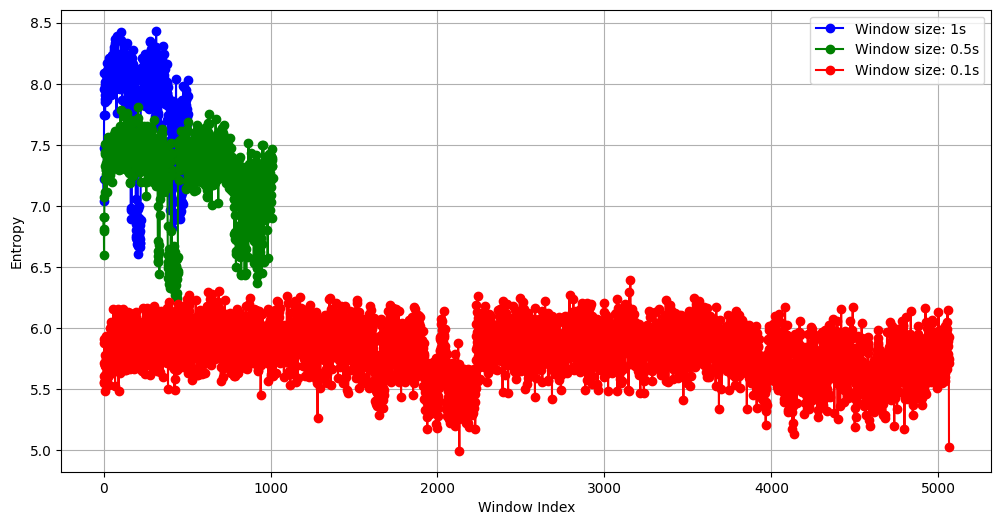

In [15]:
plot_entropy(val_entropy_dict, val_window_labels_dict, show_labels=False) 

In [16]:
window_1_labels = window_labels_dict[1]
window05_labels = window_labels_dict[0.5]
window01_labels = window_labels_dict[0.1]

val_window_1_labels = val_window_labels_dict[1]
val_window05_labels = val_window_labels_dict[0.5]
val_window_01_labels = val_window_labels_dict[0.1]

In [19]:
test_entropy_dict = {}  # Dictionary to store entropy values by window size
test_window_labels_dict = {}  # Stores window labels by window size

window_sizes = [1, 0.5, 0.1]  # in seconds
for window_size in window_sizes:
    windows, window_labels, num_windows = split_into_windows(non_perturbed_data, window_size)
    entropies = calculate_entropy(windows)
    
    # Store entropy values in dictionary
    test_entropy_dict[window_size] = entropies
    test_window_labels_dict[window_size] = window_labels
    
    print(f"Window size: {window_size} seconds")
    print(f"Number of windows: {num_windows}")
    print(f"Average entropy: {np.mean(entropies):.4f}\n")

    #Write code to group by window label and print number of windows and average entropy by window label
    # Group by window label
    test_window_label_counts = pd.Series(window_labels).value_counts()
    test_window_label_avg_entropy = pd.Series(entropies).groupby(window_labels).mean()
    test_window_label_std_entropy = pd.Series(entropies).groupby(window_labels).std()
    # print(window_label_counts)
    # print(window_label_avg_entropy)
    print("Number of attack windows: ", test_window_label_counts[1])
    print("Number of benign windows: ", test_window_label_counts[0])
    print()
    print(f"Mean and std-dev of entropy for attack windows: {test_window_label_avg_entropy[1]} and {test_window_label_std_entropy[1]}")
    print(f"Mean and std-dev of entropy for benign windows: {test_window_label_avg_entropy[0]} and {test_window_label_std_entropy[1]}") 
    print('\n\n\n')


Window size: 1 seconds
Number of windows: 69
Average entropy: 5.4523

Number of attack windows:  52
Number of benign windows:  17

Mean and std-dev of entropy for attack windows: 4.834966371608927 and 1.5408032406494894
Mean and std-dev of entropy for benign windows: 7.340757526240411 and 1.5408032406494894




Window size: 0.5 seconds
Number of windows: 138
Average entropy: 5.0549

Number of attack windows:  90
Number of benign windows:  48

Mean and std-dev of entropy for attack windows: 4.061793644317552 and 1.2025021338174644
Mean and std-dev of entropy for benign windows: 6.917093257960272 and 1.2025021338174644




Window size: 0.1 seconds
Number of windows: 686
Average entropy: 4.1634

Number of attack windows:  402
Number of benign windows:  284

Mean and std-dev of entropy for attack windows: 2.8575523864792243 and 0.6936892177824069
Mean and std-dev of entropy for benign windows: 6.011798892179457 and 0.6936892177824069






In [24]:
def detect_attack(entropy, threshold):
    """
    Detects attack based on entropy values and threshold.
    
    Args:
        entropy (list): Entropy list.
        threshold (list): Lower and upper threshold values.
        
    Returns:
        predicted_labels (list): List of predicted labels (1 if attack, else 0).
    """
    predicted_labels = []
    
    for e in entropy:
        if e < threshold[0] or e > threshold[1]:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
    
    return predicted_labels

In [25]:
# ## Write code to find median and std dev of each window size from the training set

mean_window_01, std_dev_window_01 = np.mean(entropy_dict[0.1]), np.std(entropy_dict[0.1])
mean_window_05, std_dev_window_05 = np.mean(entropy_dict[0.5]), np.std(entropy_dict[0.5])
mean_window_1, std_dev_window_1 = np.mean(entropy_dict[1]), np.std(entropy_dict[1])

fp_dict = {0.1: None, 0.5: None, 1: None}  # Dictionary to store the first k where FP turns 0

k_list = [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]


for k in k_list:

    print("Currently on k =", k)

    # Define thresholds
    threshold_01 = [mean_window_01 - k * std_dev_window_01, mean_window_01 + k * std_dev_window_01]
    threshold_05 = [mean_window_05 - k * std_dev_window_05, mean_window_05 + k * std_dev_window_05]
    threshold_1 = [mean_window_1 - k * std_dev_window_1, mean_window_1 + k * std_dev_window_1]

    # Get predictions
    val_preds_01 = detect_attack(val_entropy_dict[0.1], threshold_01)
    val_preds_05 = detect_attack(val_entropy_dict[0.5], threshold_05)
    val_preds_1 = detect_attack(val_entropy_dict[1], threshold_1)

    # Calculate false positives
    num_false_positives_01 = sum((np.array(val_window_labels_dict[0.1]) == 0) & (np.array(val_preds_01) == 1))
    num_false_positives_05 = sum((np.array(val_window_labels_dict[0.5]) == 0) & (np.array(val_preds_05) == 1))
    num_false_positives_1 = sum((np.array(val_window_labels_dict[1]) == 0) & (np.array(val_preds_1) == 1))

    print(f"Number of false positives for window size 0.1: {num_false_positives_01}")
    print(f"Number of false positives for window size 0.5: {num_false_positives_05}")
    print(f"Number of false positives for window size 1: {num_false_positives_1}\n")

    # Track first k when false positives become zero
    if num_false_positives_01 == 0 and fp_dict[0.1] is None:
        fp_dict[0.1] = k
    if num_false_positives_05 == 0 and fp_dict[0.5] is None:
        fp_dict[0.5] = k
    if num_false_positives_1 == 0 and fp_dict[1] is None:
        fp_dict[1] = k

    if num_false_positives_01 == 0 and num_false_positives_05 == 0 and num_false_positives_1 == 0:
        print("All false positives are zero. Stopping the search.")
        break

    ## For all window sizes write code to plot ROC curve for k values
    

print("First k values where false positives turn 0:", fp_dict)

Currently on k = 0.1
Number of false positives for window size 0.1: 4678
Number of false positives for window size 0.5: 941
Number of false positives for window size 1: 459

Currently on k = 0.2
Number of false positives for window size 0.1: 4256
Number of false positives for window size 0.5: 847
Number of false positives for window size 1: 430

Currently on k = 0.4
Number of false positives for window size 0.1: 3476
Number of false positives for window size 0.5: 664
Number of false positives for window size 1: 338

Currently on k = 0.5
Number of false positives for window size 0.1: 3127
Number of false positives for window size 0.5: 576
Number of false positives for window size 1: 292

Currently on k = 0.6
Number of false positives for window size 0.1: 2739
Number of false positives for window size 0.5: 485
Number of false positives for window size 1: 239

Currently on k = 0.8
Number of false positives for window size 0.1: 2086
Number of false positives for window size 0.5: 329
Number

In [26]:
# ## Create a dictionary for mean and std dev for each window size
mean_std_dict = {
    0.1: (mean_window_01, std_dev_window_01),
    0.5: (mean_window_05, std_dev_window_05),
    1: (mean_window_1, std_dev_window_1)
}

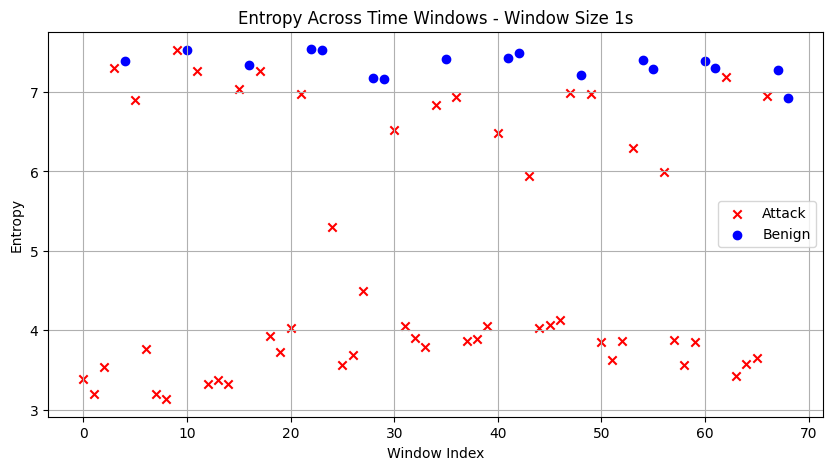

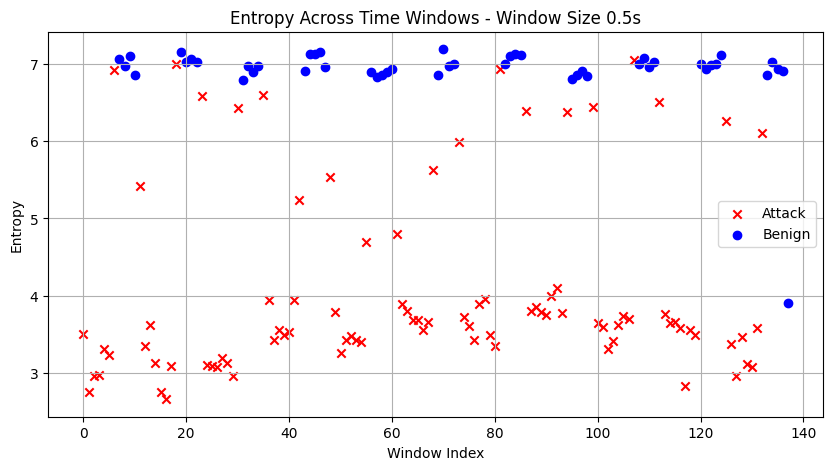

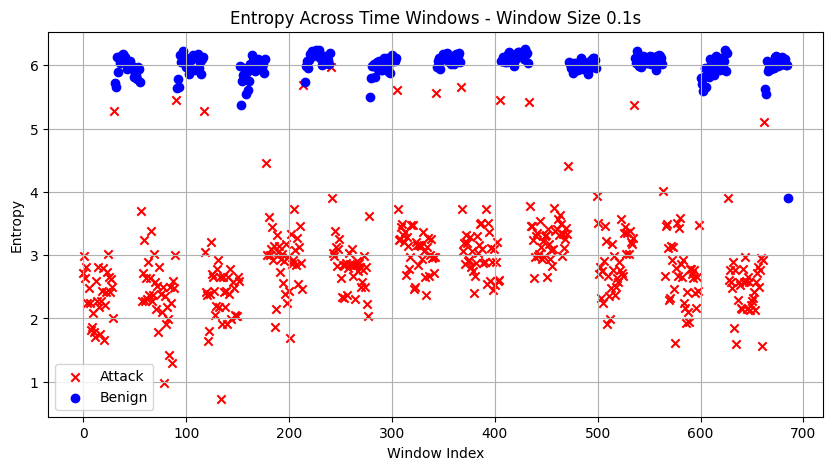

In [27]:
plot_entropy(test_entropy_dict, test_window_labels_dict, show_labels=True) 

In [28]:
def evaluate(test_entropy_dict, test_window_labels_dict, mean_std_dict, fp_dict):

    
    for window_size in test_entropy_dict.keys():
        print("Currently on window size =", window_size)

        # Define thresholds
        mean, std_dev = mean_std_dict[window_size]
        k = fp_dict[window_size]
        threshold = [mean - k * std_dev, mean + k * std_dev]
        print("Threshold: ", threshold)

        # Get true labels
        y_true = test_window_labels_dict[window_size]

        # Get predictions
        y_pred = detect_attack(test_entropy_dict[window_size], threshold)

        accuracy = accuracy_score(y_true, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        ##Write code to find absolute number of true positives, false positives, true negatives and false negatives in comparison to actual positive and negative labels
        true_positives = sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
        false_positives = sum((np.array(y_true) == 0) & (np.array(y_pred) == 1))
        true_negatives = sum((np.array(y_true) == 0) & (np.array(y_pred) == 0))
        false_negatives = sum((np.array(y_true) == 1) & (np.array(y_pred) == 0))

        print(f"True Positives / All Positives : {true_positives} / {true_positives + false_negatives} ({true_positives / (true_positives + false_negatives):.4f})")
        print(f"False Positives / All Negatives : {false_positives} / {false_positives + true_negatives} ({false_positives / (false_positives + true_negatives):.4f})")
        print(f"True Negatives / All Negatives : {true_negatives} / {false_positives + true_negatives} ({true_negatives / (false_positives + true_negatives):.4f})")
        print(f"False Negatives / All Positives : {false_negatives} / {true_positives + false_negatives} ({false_negatives / (true_positives + false_negatives):.4f})")
        
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

Currently on window size = 1
Threshold:  [6.490345496843721, 9.193051524188418]
Accuracy: 0.7971

Classification Report:
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        17
           1       1.00      0.73      0.84        52

    accuracy                           0.80        69
   macro avg       0.77      0.87      0.78        69
weighted avg       0.89      0.80      0.81        69

True Positives / All Positives : 38 / 52 (0.7308)
False Positives / All Negatives : 0 / 17 (0.0000)
True Negatives / All Negatives : 17 / 17 (1.0000)
False Negatives / All Positives : 14 / 52 (0.2692)


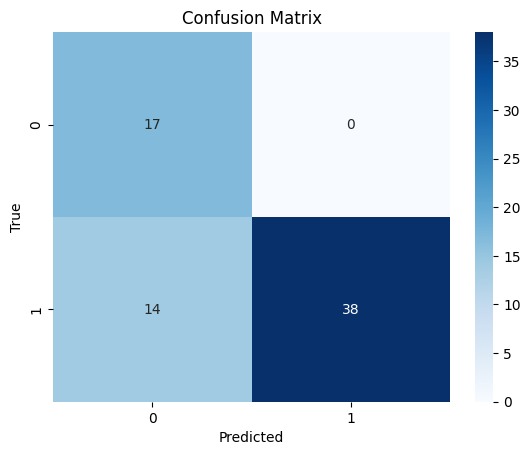

Currently on window size = 0.5
Threshold:  [6.163599872249281, 8.34838691025476]
Accuracy: 0.9058

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88        48
           1       0.99      0.87      0.92        90

    accuracy                           0.91       138
   macro avg       0.89      0.92      0.90       138
weighted avg       0.92      0.91      0.91       138

True Positives / All Positives : 78 / 90 (0.8667)
False Positives / All Negatives : 1 / 48 (0.0208)
True Negatives / All Negatives : 47 / 48 (0.9792)
False Negatives / All Positives : 12 / 90 (0.1333)


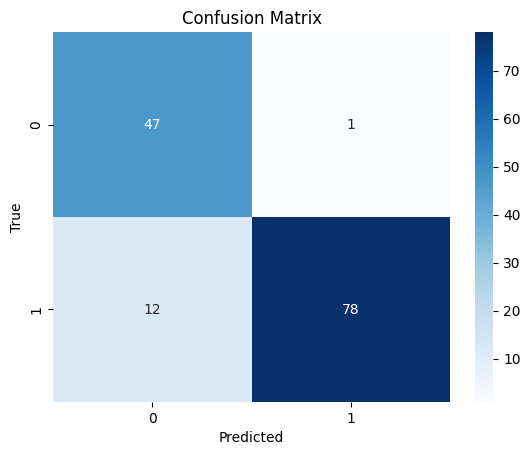

Currently on window size = 0.1
Threshold:  [4.9418928911506175, 6.6811461574985795]
Accuracy: 0.9810

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       284
           1       1.00      0.97      0.98       402

    accuracy                           0.98       686
   macro avg       0.98      0.98      0.98       686
weighted avg       0.98      0.98      0.98       686

True Positives / All Positives : 390 / 402 (0.9701)
False Positives / All Negatives : 1 / 284 (0.0035)
True Negatives / All Negatives : 283 / 284 (0.9965)
False Negatives / All Positives : 12 / 402 (0.0299)


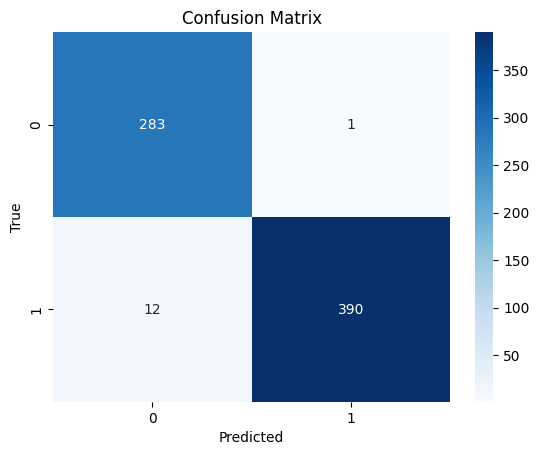

In [29]:
evaluate(test_entropy_dict, test_window_labels_dict, mean_std_dict, fp_dict)